<a href="https://colab.research.google.com/github/ppiont/cnn-soc-wagga/blob/master/rf_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scikit-optimize

     |████████████████████████████████| 102kB 4.0MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/MyDrive/Thesis/cnn-soc-wagga"

Mounted at /content/drive/
/content/drive/MyDrive/Thesis/cnn-soc-wagga


Gaussian Process:  31%|███       | 31/100 [25:46<58:03, 50.49s/it]  /usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
Gaussian Process:  37%|███▋      | 37/100 [35:35<1:17:27, 73.78s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
Gaussian Process:  39%|███▉      | 39/100 [40:33<1:43:25, 101.72s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
Gaussian Process:  45%|████▌     | 45/100 [46:04<36:38, 39.97s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warning

Best parameters:
- max_features=257
- max_depth=198
- min_samples_split=4
- min_samples_leaf=4


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff625885a90>,
      dtype=object)

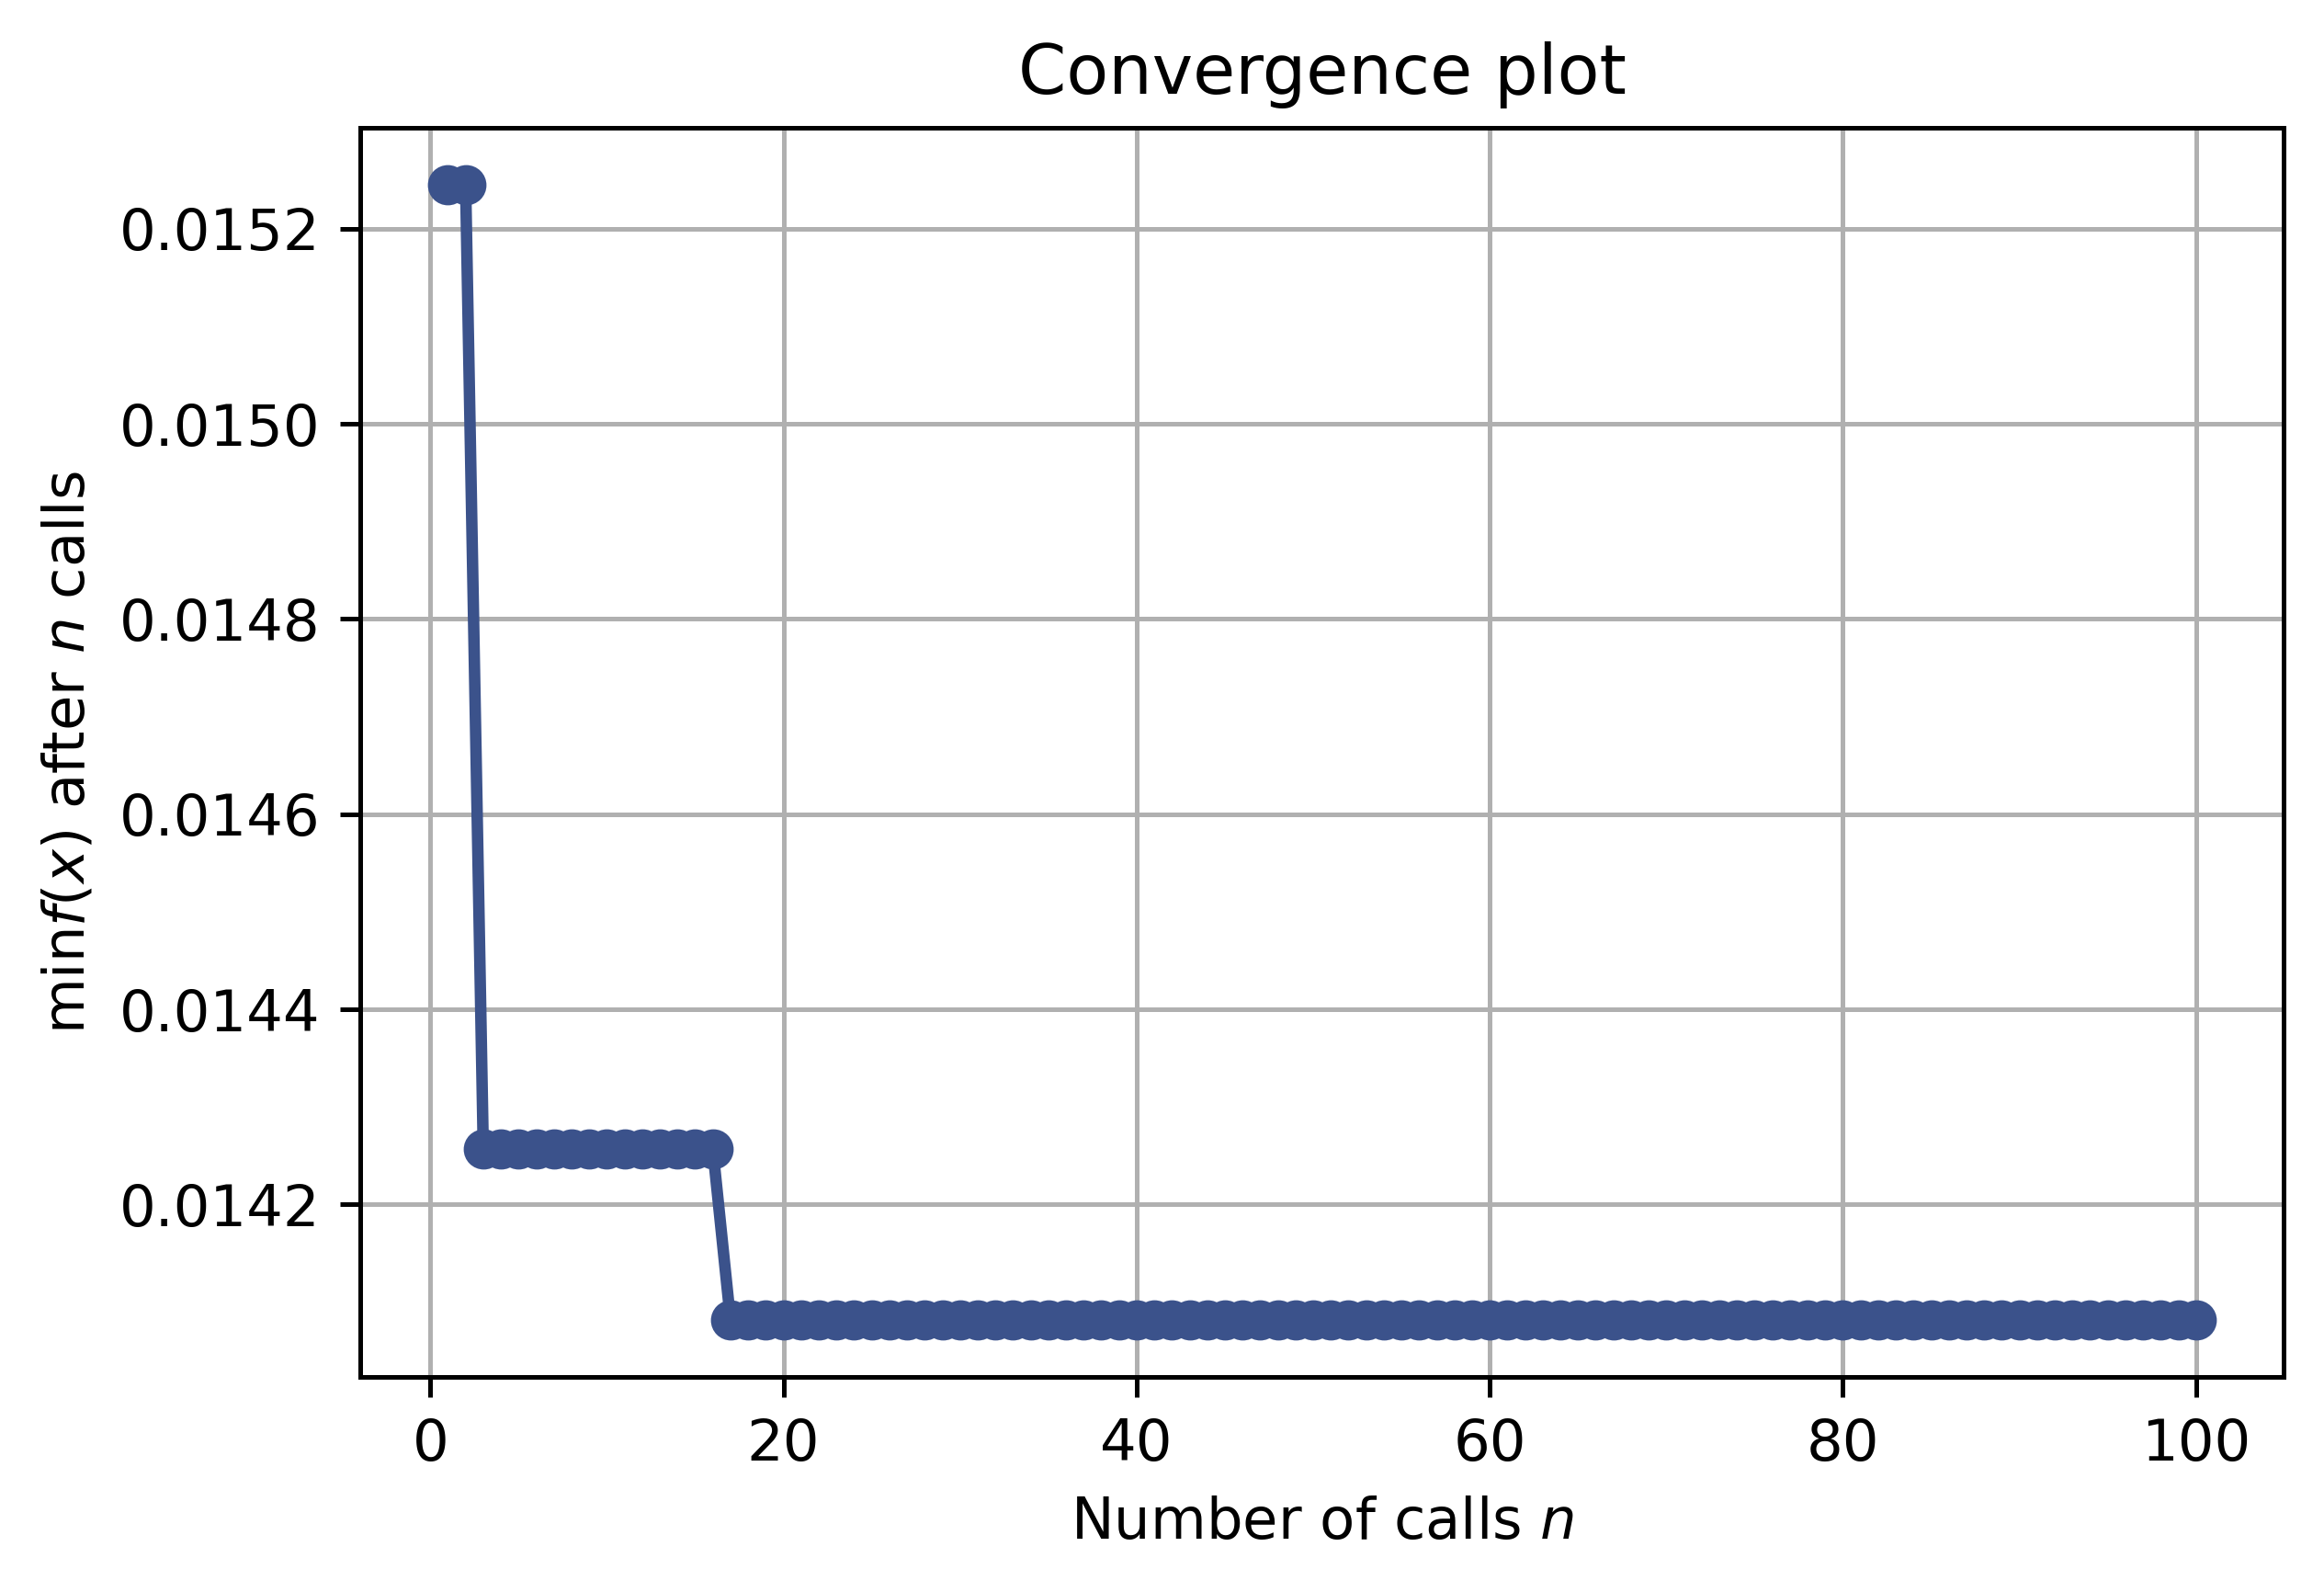

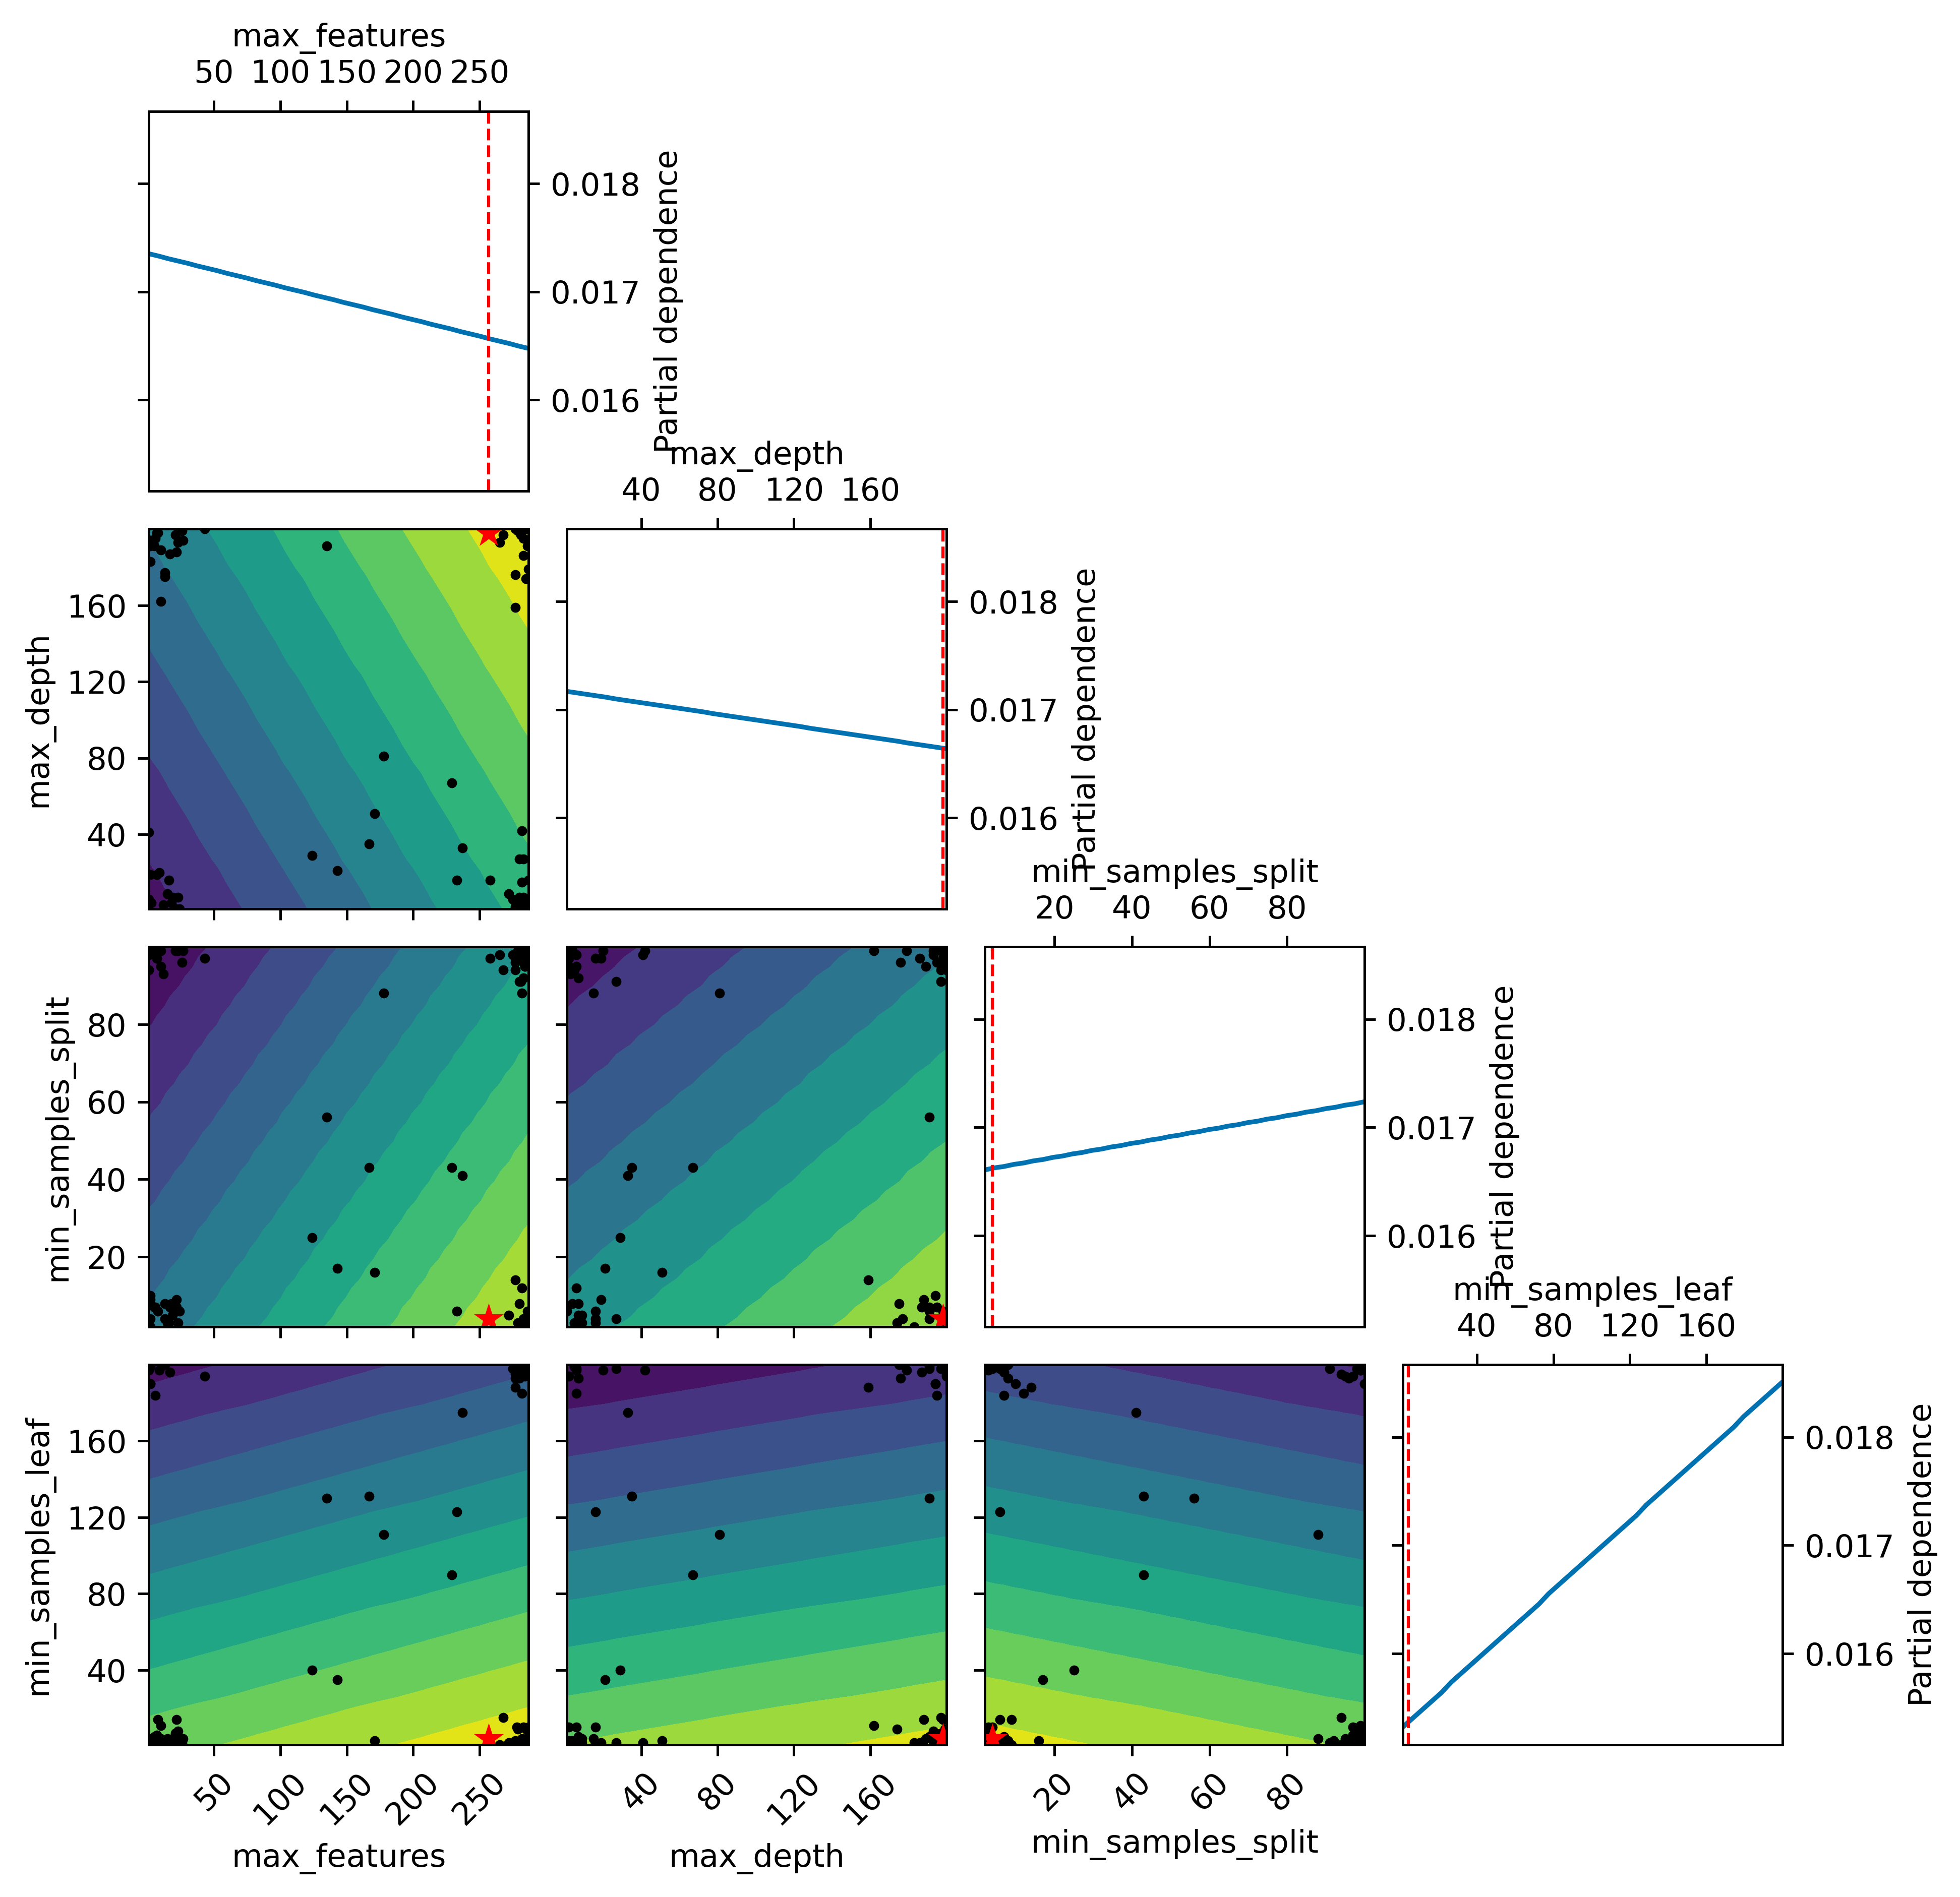

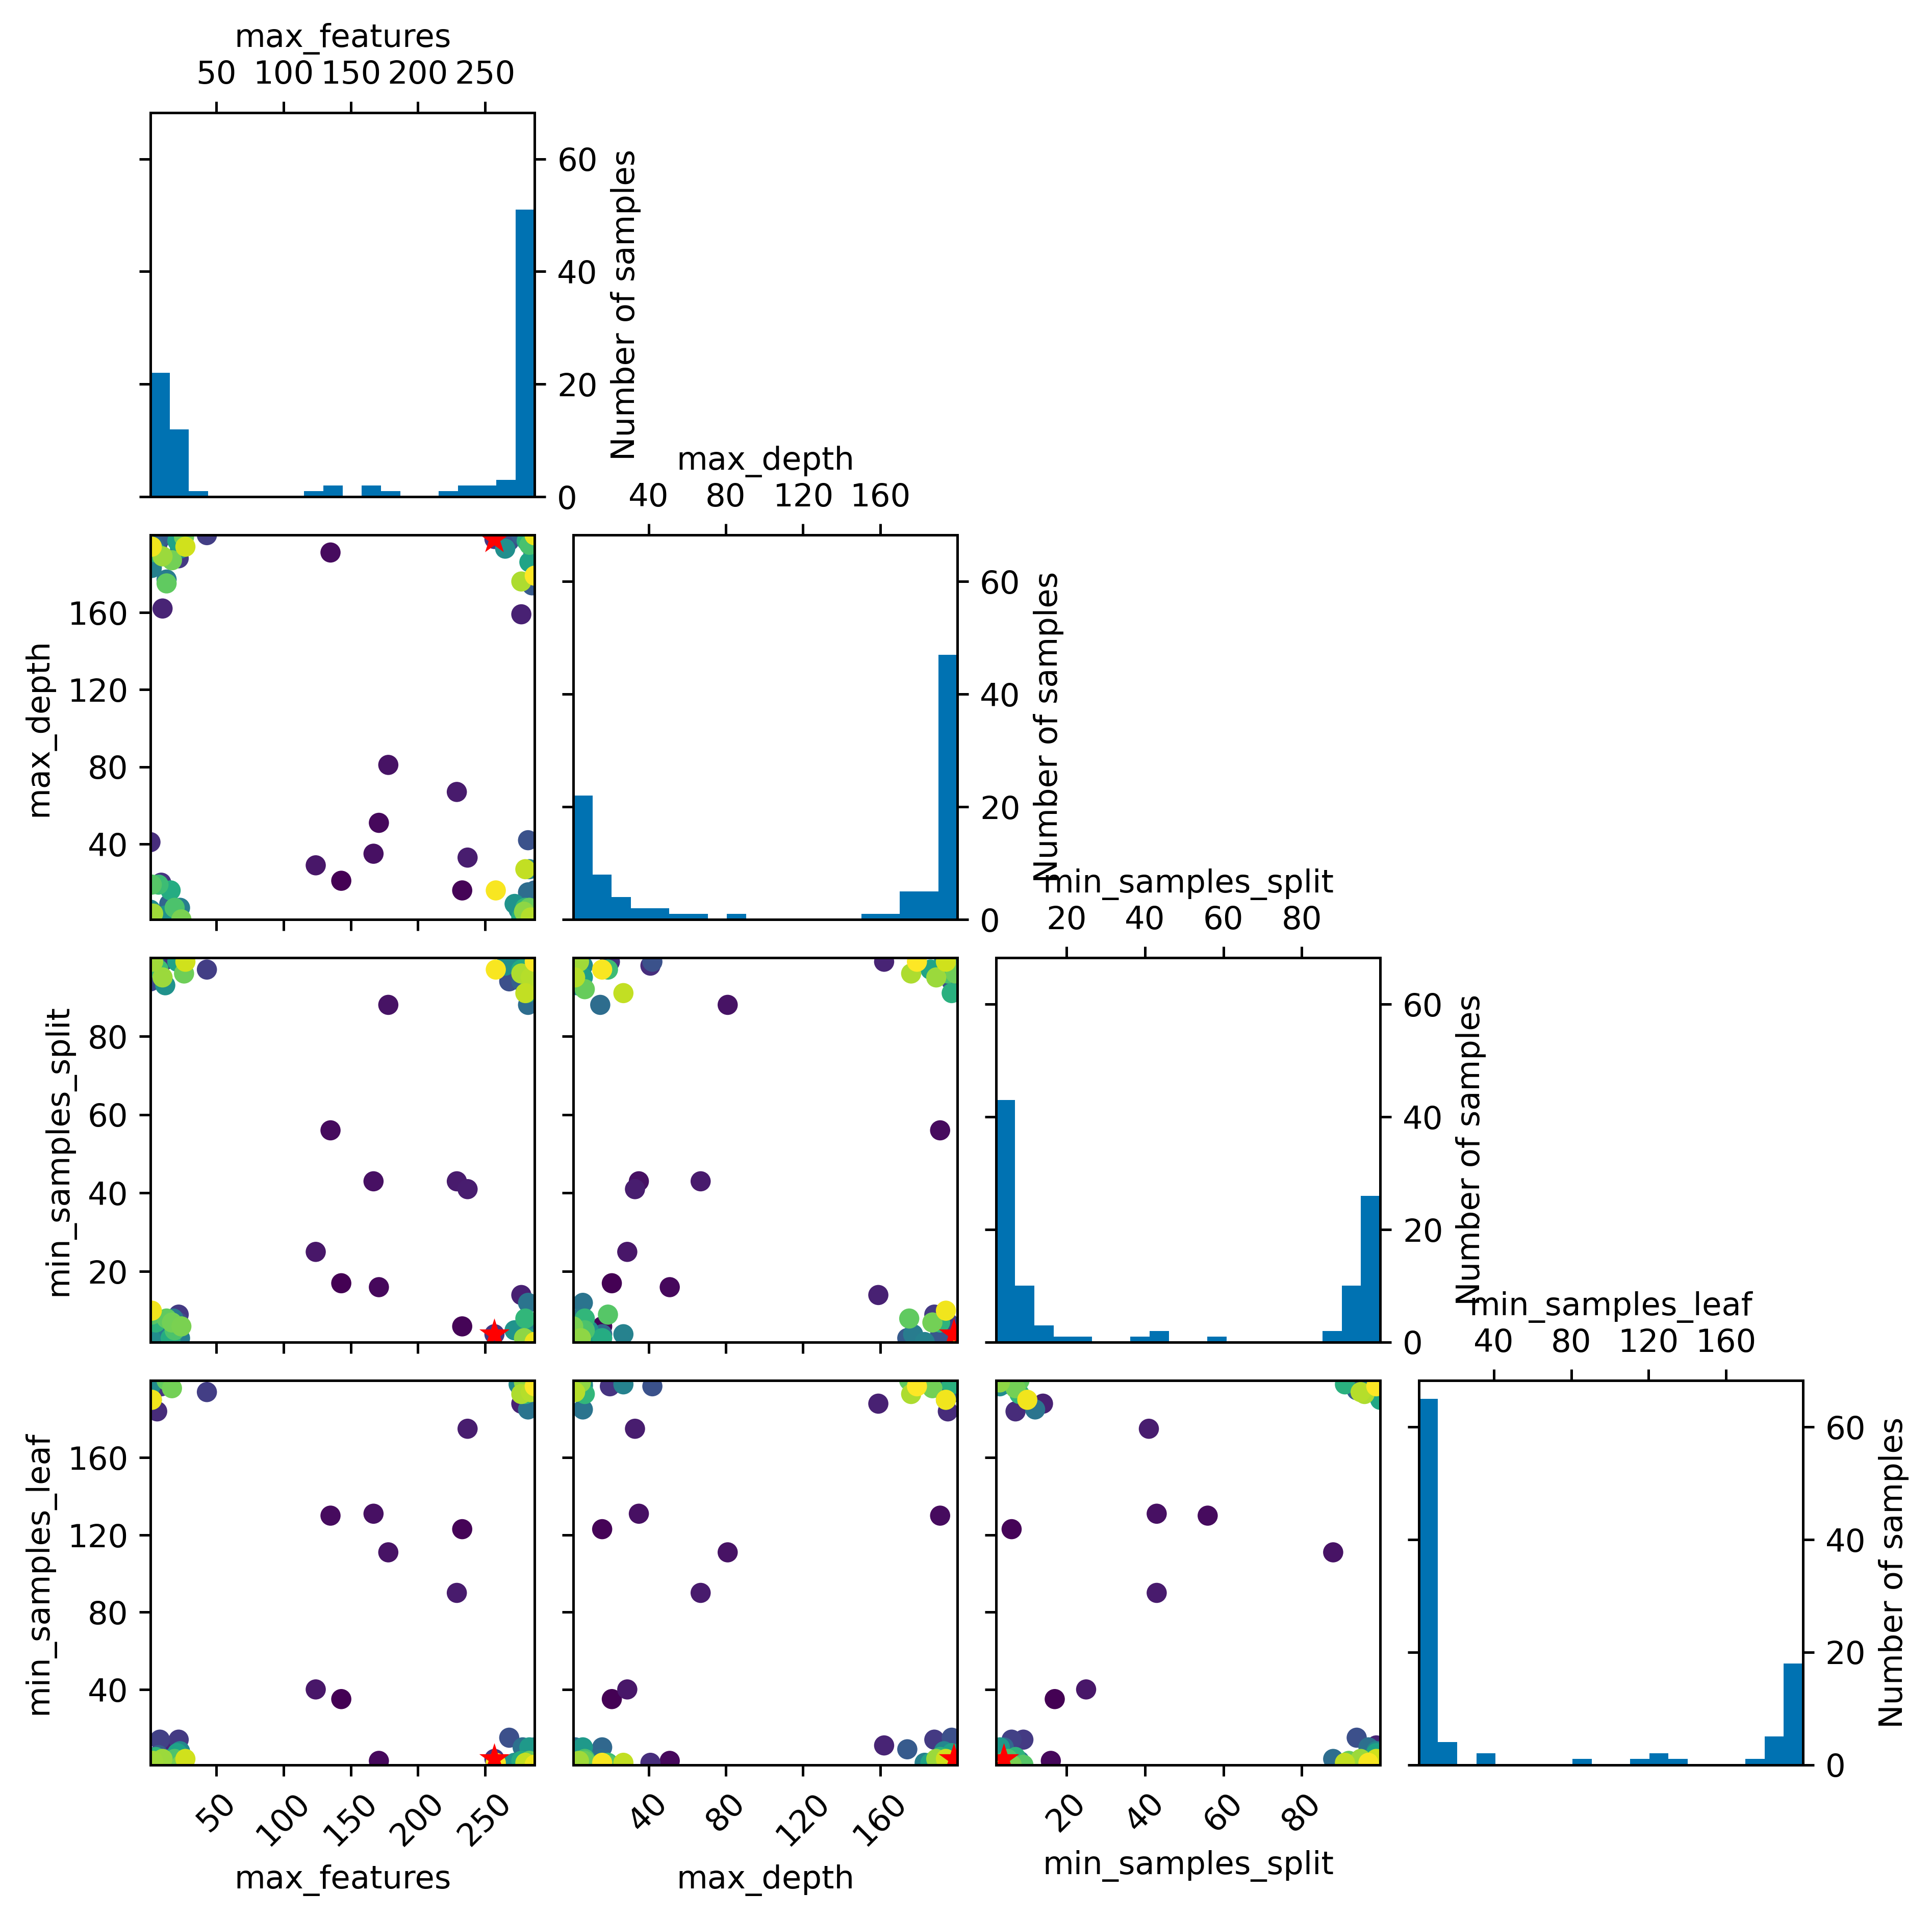

In [3]:
# Standard library imports
import pathlib

# Imports
import numpy as np
# import numpy.ma as ma
# import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from skopt.utils import use_named_args
from sklearn.preprocessing import MinMaxScaler
# from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from skopt.learning import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from skopt import gp_minimize  #, dump, load
from skopt.space import Integer  # , Real
from skopt.plots import plot_objective, plot_evaluations, plot_convergence
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

# ------------------- Settings ---------------------------------------------- #


# Set matploblib style
plt.style.use('seaborn-colorblind')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['figure.dpi'] = 450
mpl.rcParams['savefig.transparent'] = True
mpl.rcParams['savefig.format'] = 'svg'


# # Reset params if needed
# mpl.rcParams.update(mpl.rcParamsDefault)


# ------------------- Organization ------------------------------------------ #


DATA_DIR = pathlib.Path('data/')
SEED = 43


# ------------------- Read and prep data ------------------------------------ #


train_data = np.load(DATA_DIR.joinpath('train.npy'))
test_data = np.load(DATA_DIR.joinpath('test.npy'))
x_train = train_data[:, 1:]
y_train = train_data[:, 0]
x_test = test_data[:, 1:]
y_test = test_data[:, 0]

# Normalize X
scaler_x = MinMaxScaler()
scaler_x.fit(x_train)
x_train = scaler_x.transform(x_train)
x_test = scaler_x.transform(x_test)

# Normalize y
scaler_y = MinMaxScaler()
scaler_y.fit(y_train.reshape(-1, 1))
y_train = scaler_y.transform(y_train.reshape(-1, 1)).flatten()
# y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Convert data to float32
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)


# ------------------- RF Hyperparameter Optimization ------------------------ #


# Define progress monitoring object
class tqdm_skopt(object):
    """Progress bar object for functions with callbacks."""

    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)

    def __call__(self, res):
        """Update bar with intermediate results."""
        self._bar.update()

# Define estimator
estimator = RandomForestRegressor(n_estimators=500, n_jobs=-1,
                                  random_state=SEED)

# Define cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Define search space
n_features = x_train.shape[-1]

space = []
space.append(Integer(1, n_features, name='max_features'))
space.append(Integer(1, 200, name='max_depth'))
space.append(Integer(2, 100, name='min_samples_split'))
space.append(Integer(1, 200, name='min_samples_leaf'))


@use_named_args(space)
def objective(**params):
    """Return objective function score for estimator."""
    # Set hyperparameters from space decorator
    estimator.set_params(**params)

    return -np.mean(cross_val_score(estimator, x_train, y_train, cv=cv,
                                    n_jobs=-1,
                                    scoring="neg_mean_squared_error"))


n_calls = 100
res_gp = gp_minimize(objective, space, n_calls=n_calls,
                     random_state=SEED,
                     callback=[tqdm_skopt(total=n_calls,
                                          desc='Gaussian Process')])


print(f'''Best parameters:
- max_features={res_gp.x[0]}
- max_depth={res_gp.x[1]}
- min_samples_split={res_gp.x[2]}
- min_samples_leaf={res_gp.x[3]}''')

# max_features=257
# max_depth=10
# min_samples_split=23
# min_samples_leaf=13


# Plot gp_minimize output
plot_convergence(res_gp)
plot_objective(res_gp)
plot_evaluations(res_gp)
